# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.86KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

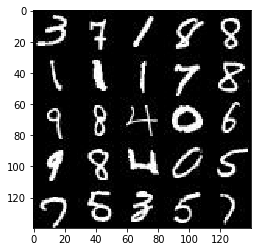

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

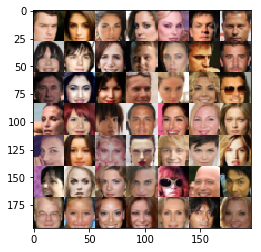

In [4]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, shape=(), name="learning_rate")

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu1, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x512
        
        x2 = tf.reshape(x1, (-1, 7, 7, 256))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14*14*128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    #d_loss_real = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    #print(data_shape)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #print(input_real)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1

                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if step % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
                    
                # At the end of each epoch, get the losses and print them out
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
            
                print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.8232... Generator Loss: 0.0141
Epoch 1/2... Discriminator Loss: 3.6868... Generator Loss: 0.0958
Epoch 1/2... Discriminator Loss: 2.9951... Generator Loss: 0.0851
Epoch 1/2... Discriminator Loss: 2.9178... Generator Loss: 0.1145
Epoch 1/2... Discriminator Loss: 2.6145... Generator Loss: 0.1367
Epoch 1/2... Discriminator Loss: 2.7896... Generator Loss: 0.1430
Epoch 1/2... Discriminator Loss: 2.5492... Generator Loss: 0.3132
Epoch 1/2... Discriminator Loss: 2.3560... Generator Loss: 0.2310
Epoch 1/2... Discriminator Loss: 2.1856... Generator Loss: 0.3566
Epoch 1/2... Discriminator Loss: 1.7507... Generator Loss: 0.4387
Epoch 1/2... Discriminator Loss: 1.8223... Generator Loss: 0.3856
Epoch 1/2... Discriminator Loss: 1.5155... Generator Loss: 0.7774
Epoch 1/2... Discriminator Loss: 1.6092... Generator Loss: 0.4115
Epoch 1/2... Discriminator Loss: 1.8272... Generator Loss: 0.4460
Epoch 1/2... Discriminator Loss: 2.0187... Generator Loss: 0.3914
Epoch 1/2.

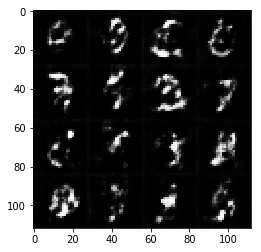

Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 0.7265
Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.7380
Epoch 1/2... Discriminator Loss: 1.6114... Generator Loss: 0.6217
Epoch 1/2... Discriminator Loss: 1.7061... Generator Loss: 0.6123
Epoch 1/2... Discriminator Loss: 1.4552... Generator Loss: 0.6941
Epoch 1/2... Discriminator Loss: 1.5119... Generator Loss: 0.6657
Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 0.8739
Epoch 1/2... Discriminator Loss: 1.4043... Generator Loss: 0.7123
Epoch 1/2... Discriminator Loss: 1.5547... Generator Loss: 0.6496
Epoch 1/2... Discriminator Loss: 1.4697... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.7604
Epoch 1/2... Discriminator Loss: 1.4271... Generator Loss: 0.7210
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.8079
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.7577
Epoch 1/2... Discriminator Loss: 1.4469... Generator Loss: 0.7408
Epoch 1/2.

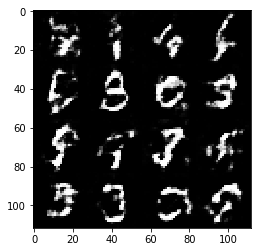

Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 0.6842
Epoch 1/2... Discriminator Loss: 1.4318... Generator Loss: 0.6755
Epoch 1/2... Discriminator Loss: 1.4578... Generator Loss: 0.6725
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 0.7324
Epoch 1/2... Discriminator Loss: 1.4286... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 0.6861
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 0.6895
Epoch 1/2... Discriminator Loss: 1.4251... Generator Loss: 0.7311
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 1.4351... Generator Loss: 0.6937
Epoch 1/2... Discriminator Loss: 1.4319... Generator Loss: 0.8298
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 1.4191... Generator Loss: 0.7446
Epoch 1/2.

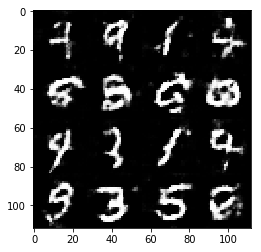

Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 0.6789
Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.4217... Generator Loss: 0.7376
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 1.3498... Generator Loss: 0.7788
Epoch 1/2... Discriminator Loss: 1.4494... Generator Loss: 0.7331
Epoch 1/2... Discriminator Loss: 1.5717... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 0.7113
Epoch 1/2... Discriminator Loss: 1.4531... Generator Loss: 0.7159
Epoch 1/2... Discriminator Loss: 1.4365... Generator Loss: 0.6566
Epoch 1/2... Discriminator Loss: 1.5303... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.5222... Generator Loss: 0.6423
Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 1.4400... Generator Loss: 0.7241
Epoch 1/2... Discriminator Loss: 1.4632... Generator Loss: 0.7693
Epoch 1/2.

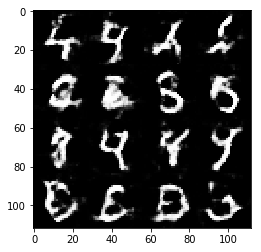

Epoch 1/2... Discriminator Loss: 1.5102... Generator Loss: 0.7344
Epoch 1/2... Discriminator Loss: 1.4829... Generator Loss: 0.6825
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.7550
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.7406
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.6576
Epoch 1/2... Discriminator Loss: 1.5191... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.7057
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 0.7163
Epoch 1/2... Discriminator Loss: 1.4458... Generator Loss: 0.7662
Epoch 1/2... Discriminator Loss: 1.4718... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 1.5463... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.4318... Generator Loss: 0.7382
Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 1.4610... Generator Loss: 0.7116
Epoch 1/2.

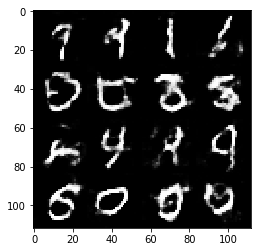

Epoch 1/2... Discriminator Loss: 1.3146... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.7732
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 1.4515... Generator Loss: 0.7279
Epoch 1/2... Discriminator Loss: 1.3530... Generator Loss: 0.8051
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.7662
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 1.4612... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.7080
Epoch 1/2.

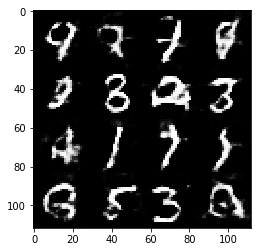

Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 1.4301... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 1.5056... Generator Loss: 0.6991
Epoch 1/2... Discriminator Loss: 1.3474... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 0.7774
Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 0.7027
Epoch 1/2... Discriminator Loss: 1.4148... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.7274
Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.4007... Generator Loss: 0.7700
Epoch 1/2... Discriminator Loss: 1.4631... Generator Loss: 0.7212
Epoch 1/2... Discriminator Loss: 1.3479... Generator Loss: 0.7619
Epoch 1/2.

In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.4218... Generator Loss: 0.0032
Epoch 1/1... Discriminator Loss: 4.4449... Generator Loss: 0.0220
Epoch 1/1... Discriminator Loss: 4.1630... Generator Loss: 0.0312
Epoch 1/1... Discriminator Loss: 3.2945... Generator Loss: 0.0690
Epoch 1/1... Discriminator Loss: 3.5047... Generator Loss: 0.0551
Epoch 1/1... Discriminator Loss: 3.1022... Generator Loss: 0.1060
Epoch 1/1... Discriminator Loss: 2.7353... Generator Loss: 0.1365
Epoch 1/1... Discriminator Loss: 3.2736... Generator Loss: 0.0730
Epoch 1/1... Discriminator Loss: 2.2152... Generator Loss: 0.2804
Epoch 1/1... Discriminator Loss: 3.0752... Generator Loss: 0.0889
Epoch 1/1... Discriminator Loss: 2.0307... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 2.6027... Generator Loss: 0.1835
Epoch 1/1... Discriminator Loss: 3.1358... Generator Loss: 0.0896
Epoch 1/1... Discriminator Loss: 1.8786... Generator Loss: 1.3969
Epoch 1/1... Discriminator Loss: 4.4161... Generator Loss: 0.0235
Epoch 1/1.

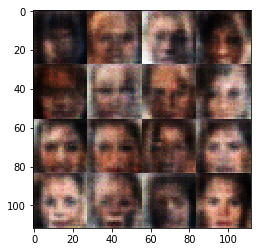

Epoch 1/1... Discriminator Loss: 1.9083... Generator Loss: 0.3848
Epoch 1/1... Discriminator Loss: 1.8773... Generator Loss: 0.4090
Epoch 1/1... Discriminator Loss: 1.8963... Generator Loss: 0.3935
Epoch 1/1... Discriminator Loss: 1.8509... Generator Loss: 0.4367
Epoch 1/1... Discriminator Loss: 1.8157... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 1.7860... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 1.7482... Generator Loss: 0.4304
Epoch 1/1... Discriminator Loss: 1.9065... Generator Loss: 0.4088
Epoch 1/1... Discriminator Loss: 2.0015... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.8974... Generator Loss: 0.4322
Epoch 1/1... Discriminator Loss: 1.8408... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 1.9056... Generator Loss: 0.3862
Epoch 1/1... Discriminator Loss: 1.8785... Generator Loss: 0.3975
Epoch 1/1... Discriminator Loss: 1.8928... Generator Loss: 0.4279
Epoch 1/1... Discriminator Loss: 2.1969... Generator Loss: 0.2996
Epoch 1/1.

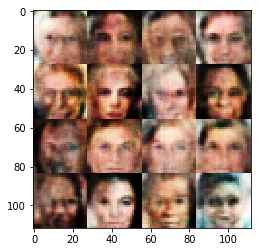

Epoch 1/1... Discriminator Loss: 1.8366... Generator Loss: 0.4177
Epoch 1/1... Discriminator Loss: 1.7080... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 1.8335... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.8442... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 1.9400... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 1.7879... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.8690... Generator Loss: 0.4552
Epoch 1/1... Discriminator Loss: 1.6874... Generator Loss: 0.4388
Epoch 1/1... Discriminator Loss: 1.7134... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.7949... Generator Loss: 0.3794
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 1.7573... Generator Loss: 0.4217
Epoch 1/1... Discriminator Loss: 1.7127... Generator Loss: 0.4891
Epoch 1/1... Discriminator Loss: 1.6330... Generator Loss: 0.5055
Epoch 1/1.

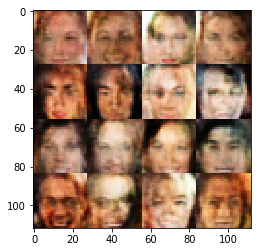

Epoch 1/1... Discriminator Loss: 1.8304... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 1.7043... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 1.7057... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 1.8914... Generator Loss: 0.3836
Epoch 1/1... Discriminator Loss: 1.7965... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.7231... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 1.7451... Generator Loss: 0.4502
Epoch 1/1... Discriminator Loss: 1.8053... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.7172... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 1.7573... Generator Loss: 0.4506
Epoch 1/1... Discriminator Loss: 1.8410... Generator Loss: 0.4475
Epoch 1/1... Discriminator Loss: 1.6971... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.7488... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.7710... Generator Loss: 0.4569
Epoch 1/1.

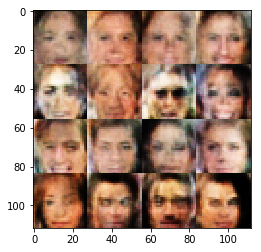

Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.6942... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.6762... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.6915... Generator Loss: 0.4415
Epoch 1/1... Discriminator Loss: 2.0447... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 1.6398... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.8604... Generator Loss: 0.3674
Epoch 1/1... Discriminator Loss: 1.7902... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 1.6906... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.7865... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.8415... Generator Loss: 0.4346
Epoch 1/1... Discriminator Loss: 2.0488... Generator Loss: 0.4228
Epoch 1/1... Discriminator Loss: 1.9065... Generator Loss: 0.4400
Epoch 1/1.

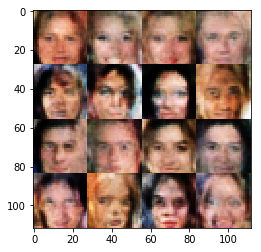

Epoch 1/1... Discriminator Loss: 1.7118... Generator Loss: 0.4290
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.6041... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.8183... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 1.5736... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 0.5014
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.9249
Epoch 1/1.

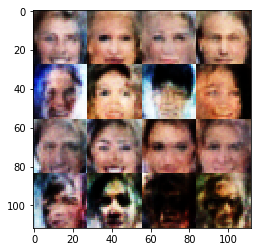

Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.5261
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 1.8380... Generator Loss: 0.3114
Epoch 1/1... Discriminator Loss: 1.7913... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.8361... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 1.7524
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 2.4114
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.8897... Generator Loss: 0.2979
Epoch 1/1... Discriminator Loss: 1.7470... Generator Loss: 0.3544
Epoch 1/1... Discriminator Loss: 1.7508... Generator Loss: 0.3796
Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 2.3218
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.5165
Epoch 1/1... Discriminator Loss: 1.8457... Generator Loss: 0.2937
Epoch 1/1.

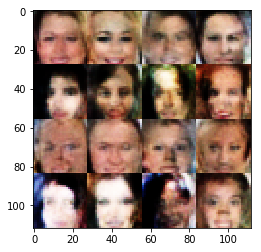

Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 1.4357
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 2.2017
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.7480... Generator Loss: 0.3154
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 2.3123
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.6964... Generator Loss: 0.3723
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.4651
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.8385
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.6750... Generator Loss: 0.3529
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.3769
Epoch 1/1.

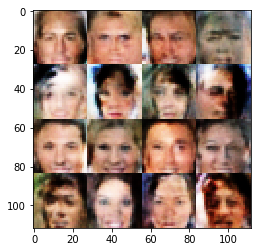

Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.3861
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 2.1510
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 2.8584
Epoch 1/1... Discriminator Loss: 1.8099... Generator Loss: 0.3100
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.3809
Epoch 1/1... Discriminator Loss: 0.6257... Generator Loss: 2.0720
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 2.0956
Epoch 1/1... Discriminator Loss: 1.8460... Generator Loss: 0.2767
Epoch 1/1.

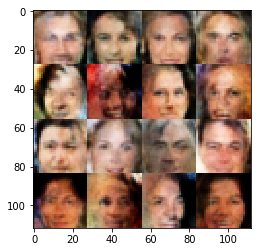

Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.5477
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 1.3979
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.2051
Epoch 1/1... Discriminator Loss: 1.5804... Generator Loss: 0.3994
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.7725
Epoch 1/1.

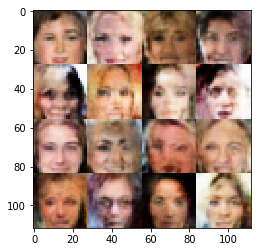

Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.4357
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 2.3097
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 2.0283
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.3318
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.1778
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 1.2046
Epoch 1/1.

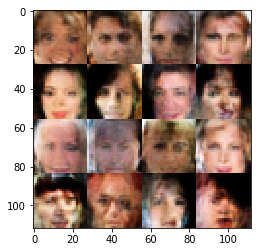

Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.4363
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 2.3536
Epoch 1/1.

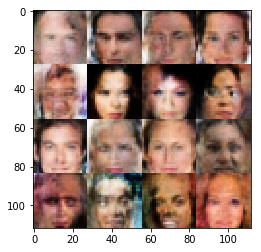

Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 1.4545
Epoch 1/1... Discriminator Loss: 1.9491... Generator Loss: 0.2465
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 0.6864... Generator Loss: 2.4830
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 1.5906
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 1.6819
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6839
Epoch 1/1.

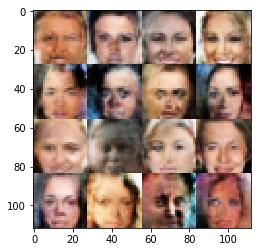

Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.9677
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 1.7499
Epoch 1/1... Discriminator Loss: 1.8814... Generator Loss: 0.2800
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.8708
Epoch 1/1.

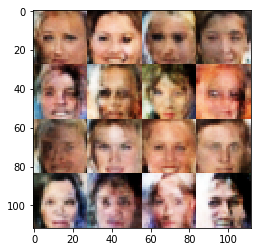

Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.5767
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 1.6084
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 1.2469
Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 0.4037
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.3087
Epoch 1/1.

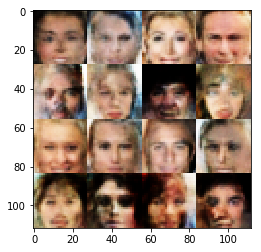

Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.5829
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.5540
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 1.8560
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.4685
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.6338
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.4218
Epoch 1/1.

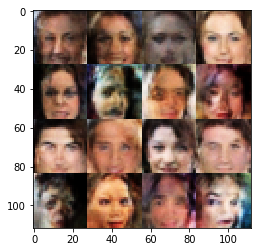

Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.1369
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 2.5618
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.8739
Epoch 1/1.

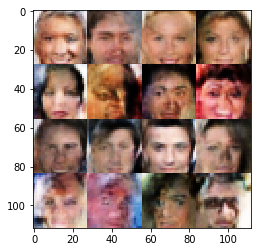

Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 1.1992
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.6876
Epoch 1/1.

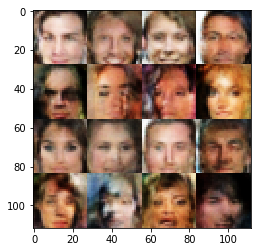

Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 2.2273
Epoch 1/1.

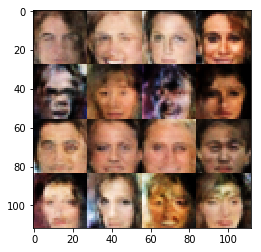

Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 2.6413
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 2.9705
Epoch 1/1... Discriminator Loss: 1.7868... Generator Loss: 1.6021
Epoch 1/1... Discriminator Loss: 1.8411... Generator Loss: 1.8582
Epoch 1/1... Discriminator Loss: 1.8719... Generator Loss: 1.9126
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 1.0391
Epoch 1/1.

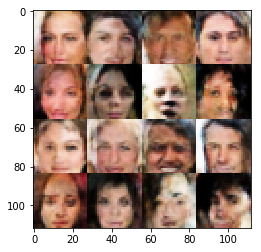

Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 2.7709
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.8480
Epoch 1/1.

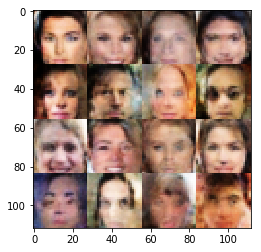

Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.8019
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.6427
Epoch 1/1.

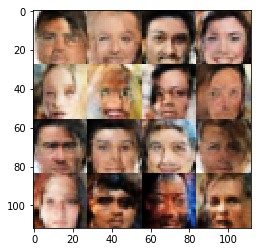

Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.2331
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 1.2763
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.4535
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 2.2005
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.7087
Epoch 1/1.

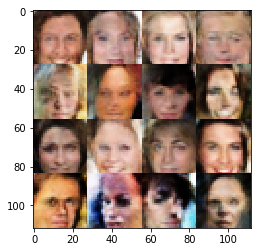

Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.9327
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.1671
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.1105
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.4174
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.8046
Epoch 1/1.

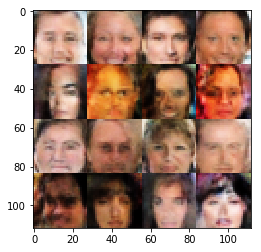

Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.7293... Generator Loss: 0.3551
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 1.4321
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.7094
Epoch 1/1.

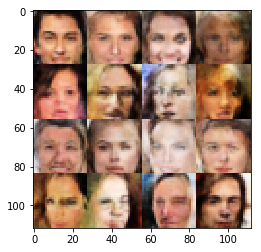

Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.1559
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.6935
Epoch 1/1.

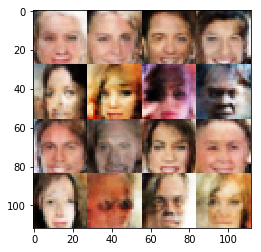

Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.6716
Epoch 1/1.

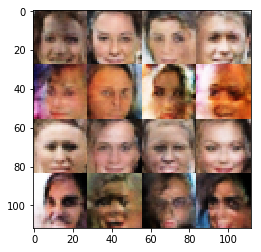

Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 1.1548
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 2.2546
Epoch 1/1... Discriminator Loss: 2.0223... Generator Loss: 2.5050
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.7344... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.6567
Epoch 1/1.

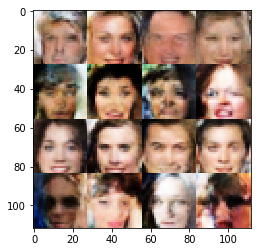

Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.2781
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.7367
Epoch 1/1.

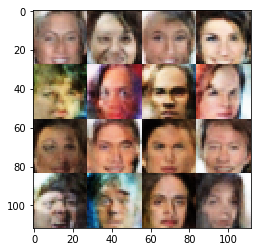

Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.0996
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 2.8145
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.7938... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 1.1001
Epoch 1/1.

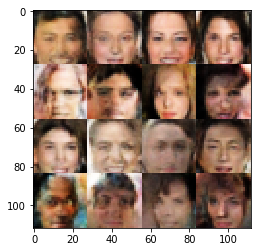

Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.3814
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.4413
Epoch 1/1.

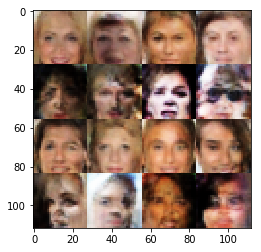

Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.5777
Epoch 1/1.

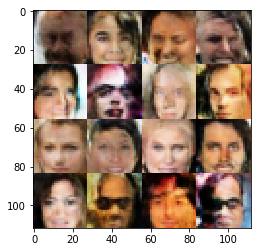

Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 2.3145
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8088
Epoch 1/1.

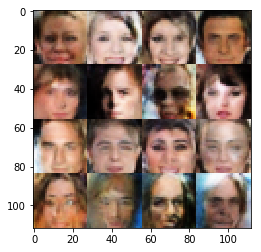

Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.6161
Epoch 1/1.

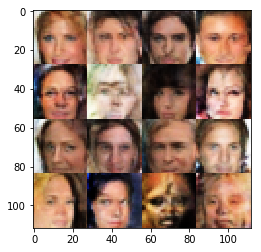

Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.7984
Epoch 1/1.

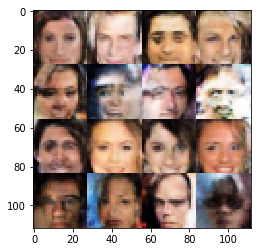

Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.7006... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6546
Epoch 1/1.

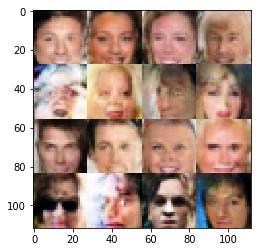

Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 2.6960
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.6965
Epoch 1/1.

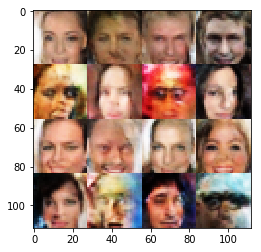

Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.7696
Epoch 1/1.

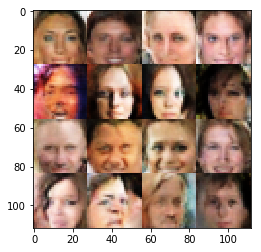

Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.6536
Epoch 1/1.

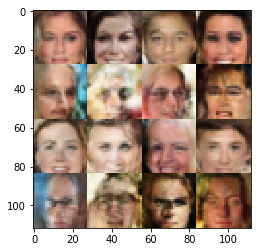

Epoch 1/1... Discriminator Loss: 1.6598... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.6466
Epoch 1/1.

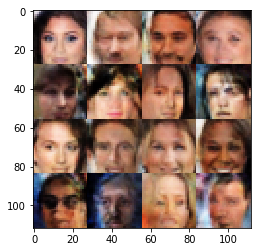

Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 1.2506
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.6379
Epoch 1/1.

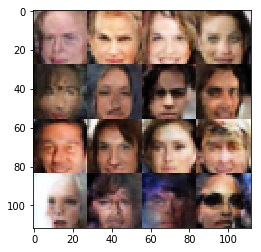

Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.5739
Epoch 1/1.

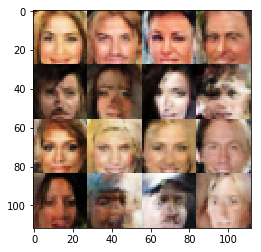

Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.9096
Epoch 1/1.

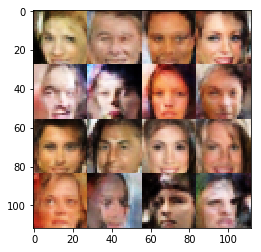

Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.9158
Epoch 1/1.

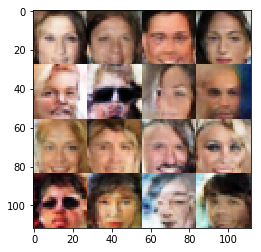

Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.6363... Generator Loss: 0.4845
Epoch 1/1.

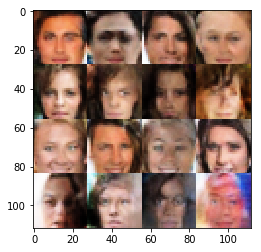

Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 1.7984
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.6484... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6442
Epoch 1/1.

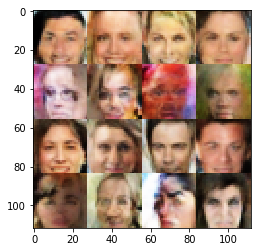

Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7275
Epoch 1/1.

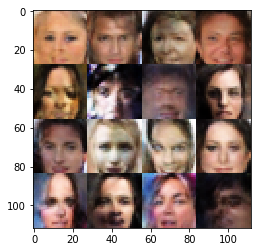

Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.5445
Epoch 1/1.

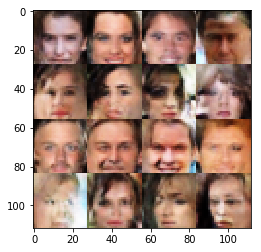

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7520
Epoch 1/1.

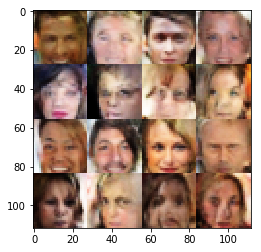

Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.8275
Epoch 1/1.

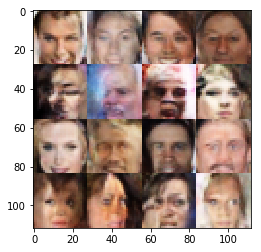

Epoch 1/1... Discriminator Loss: 2.0140... Generator Loss: 1.4347
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.5999... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.6884
Epoch 1/1.

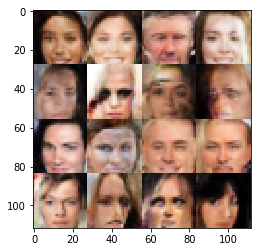

Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.8304
Epoch 1/1.

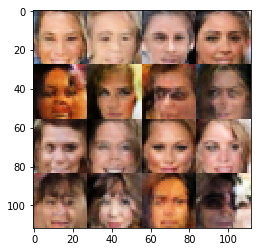

Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.4353
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.7104
Epoch 1/1.

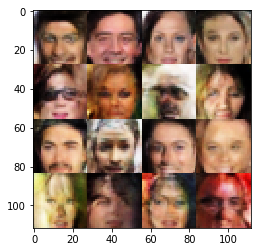

Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.5225
Epoch 1/1.

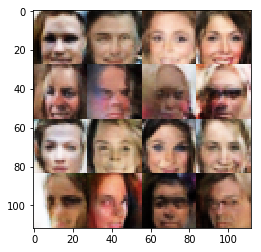

Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.8210
Epoch 1/1.

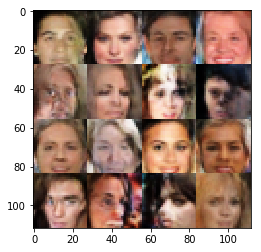

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.6232
Epoch 1/1.

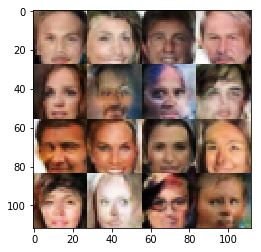

Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.6876
Epoch 1/1.

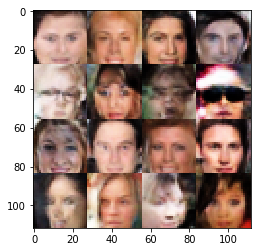

Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.9064
Epoch 1/1.

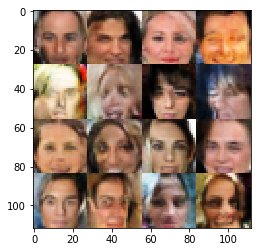

Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.7005
Epoch 1/1.

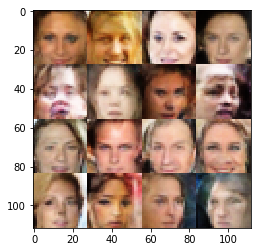

Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.6762
Epoch 1/1.

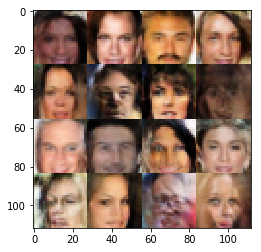

Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 1.6441... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.5986
Epoch 1/1.

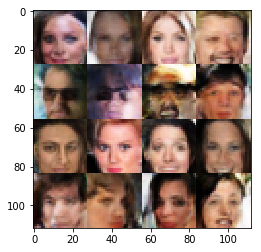

Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.5976... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.7982
Epoch 1/1.

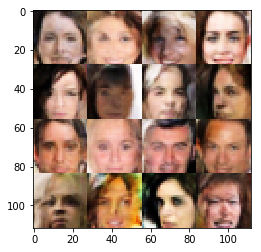

Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 1.6469
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.6859
Epoch 1/1.

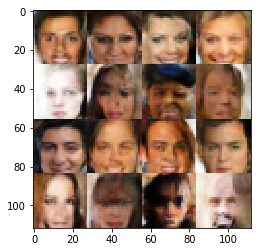

Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.4399
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.7508
Epoch 1/1.

In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.